In [9]:
import pandas as pd
from pandas import read_csv
import numpy as np
import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

In [10]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_2a6866732d1a44eba9e4b76db082313f = 'https://s3.eu.cloud-object-storage.appdomain.cloud'
else:
    endpoint_2a6866732d1a44eba9e4b76db082313f = 'https://s3.private.eu.cloud-object-storage.appdomain.cloud'

client_2a6866732d1a44eba9e4b76db082313f = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='gbgrPgNRwl7mfe0hIiRRdDFVy7B1M26nEDo0mzYW-hta',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_2a6866732d1a44eba9e4b76db082313f)

body = client_2a6866732d1a44eba9e4b76db082313f.get_object(Bucket='timeseriesforecasting-donotdelete-pr-njlnalihkos8fx',Key='AirPassengers.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df= pd.read_csv(body,parse_dates=['Month'], index_col='Month',date_parser=dateparse)
df.head()

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from ipykernel import kernelapp as app


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


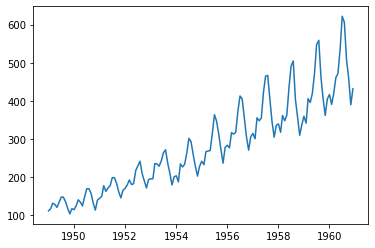

In [12]:
plt.plot(df)
plt.show()

In [13]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

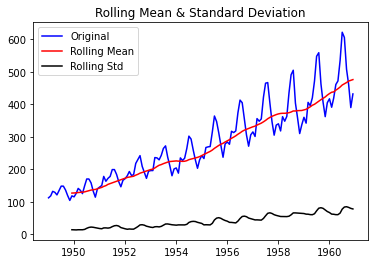

In [14]:
test_stationarity(df)

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

constant mean<br>
constant variance<br>
an autocovariance that does not depend on time.<br>
 There are 2 major reasons behind non-stationaruty of a TS:

Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.<br>
Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

In [15]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset["#Passengers"][i] - dataset["#Passengers"][i - interval]
        diff.append(value)
    return (diff)

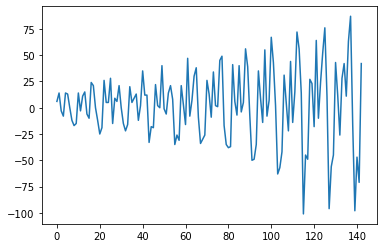

In [16]:
diff = difference(df)
plt.plot(diff)
plt.show()

This is not working well as there is an increasing positive trend

So we have to apply transformation which penalize higher values more than smaller values.
Lets take a log transform here for simplicity:

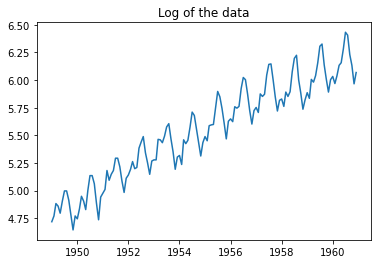

In [19]:
ts_log = np.log(df)
plt.title('Log of the data')
plt.plot(ts_log)
plt.show()

## Moving Average

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

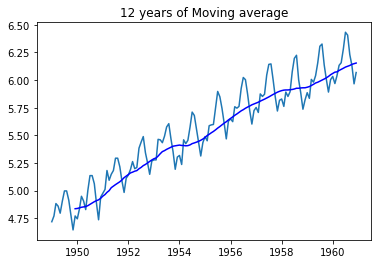

In [20]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.title('12 years of Moving average')
plt.plot(moving_avg, color='blue')
plt.show()

The blue line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [21]:
ts_log_moving_avg_diff = ts_log - moving_avg

since we are taking average of last 12 values, rolling mean is not defined for first 11 values. So we remove the NAN values

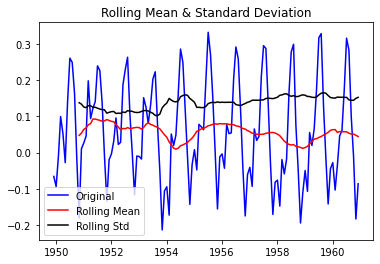

In [22]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Weighted Moving Average: Here more recent values are given a higher weight

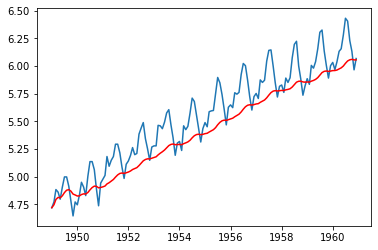

In [23]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
#parameter halflife is used to define the amount of exponential decay
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

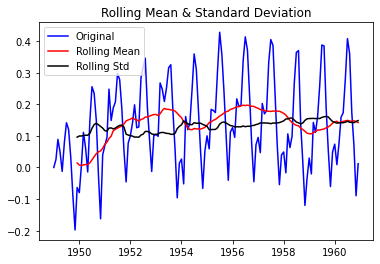

In [24]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality
The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

Differencing – taking the differece with a particular time lag<br>
Decomposition – modeling both trend and seasonality and removing them from the model.

## Differencing

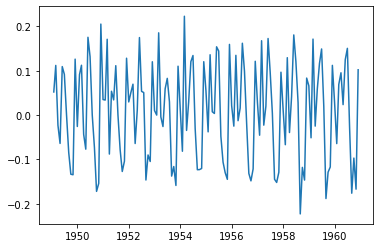

In [25]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

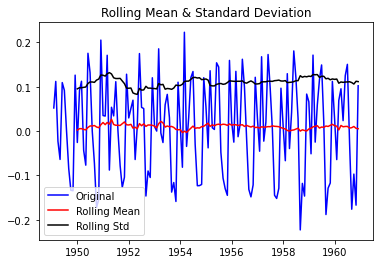

In [26]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Decomposition

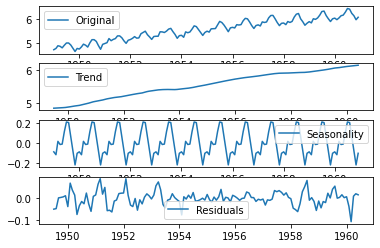

<Figure size 432x288 with 0 Axes>

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals

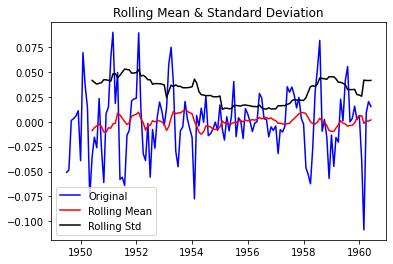

In [28]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


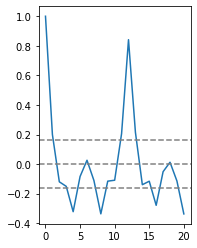

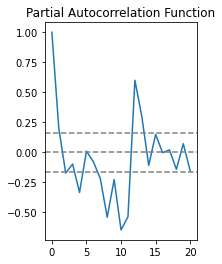

<Figure size 432x288 with 0 Axes>

In [29]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.show()
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()
plt.tight_layout()


In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2<br>
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.
## AR model

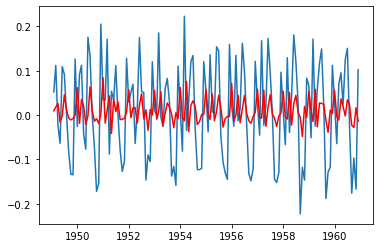

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order=(2, 1, 0), freq=ts_log.index.inferred_freq)  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.show()

## MA Model

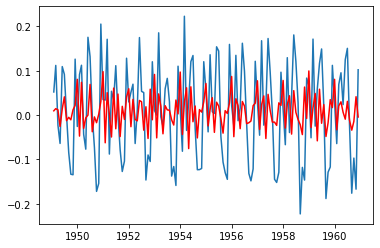

In [31]:
model = ARIMA(ts_log, order=(0, 1, 2), freq=ts_log.index.inferred_freq)  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.show()

## ARIMA Model

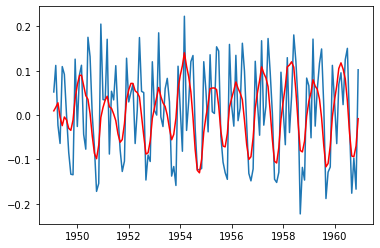

In [32]:
model = ARIMA(ts_log, order=(2, 1, 2), freq=ts_log.index.inferred_freq)  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.show()

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better.